In [1]:
import warnings
warnings.filterwarnings('ignore')

# Approche classique: embeddings de mots

In [2]:
import pandas as pd

In [3]:
train_df = pd.read_csv("./data/train_df.csv", index_col=0)
test_df = pd.read_csv("./data/test_df.csv", index_col=0)

In [4]:
train_df.shape

(3395, 11)

In [5]:
test_df.shape

(1455, 11)

In [6]:
y_train = train_df["target"]
y_test = test_df["target"]

### Embeddings de comptage des mots

En réalisant les embeddings de façon indépendante sur le jeu de train et de test on s'assure qu'il n'y a pas de fuite de données et que l'appréciation de performance du modèle ne sera pas biaisée. Cependant il y a un fort risque d'avoir des OOV lors du test.

In [7]:
train_df .head()#["preprocessed_text"].isna().sum()

,target,ids,date,flag,user,text,cleaned_text,tokenized,preprocessed_text,preprocessed_tokenized,sentiment_score
970039,1,1828003177,Sun May 17 11:53:32 PDT 2009,NO_QUERY,xeniavives,@DitaVonTeese La Duree in the Paris airport???...,La Duree in the Paris airport?? Good to know,"['La', 'Duree', 'in', 'the', 'Paris', 'airport...",la duree paris airport ? ? good know,"['la', 'duree', 'paris', 'airport', '?', '?', ...",1
692250,0,2252448245,Sat Jun 20 06:17:19 PDT 2009,NO_QUERY,cindymanila,"finally, at the airport. currently chilling ou...","Finally, at the airport. Currently chilling ou...","['Finally', ',', 'at', 'the', 'airport', '.', ...",finally airport currently chilling citibank ...,"['finally', 'airport', 'currently', 'chilling'...",0
642603,0,2235544537,Fri Jun 19 01:28:15 PDT 2009,NO_QUERY,k8greene,"Ah man, the new iphone is out today and I have...","Ah man, the new iphone is out today and I have...","['Ah', 'man', ',', 'the', 'new', 'iphone', 'is...",ah man new iphone today wait several week upg...,"['ah', 'man', 'new', 'iphone', 'today', 'wait'...",1
138290,0,1880526582,Fri May 22 01:33:33 PDT 2009,NO_QUERY,iGustavo,I'm feeling a little tired I'm so going to sl...,I'm feeling a little tired I'm so going to sle...,"['I', ""'m"", 'feeling', 'a', 'little', 'tired',...",'m feeling little tired 'm going sleep plane ...,"[""'m"", 'feeling', 'little', 'tired', ""'m"", 'go...",0
114481,0,1826311960,Sun May 17 08:12:26 PDT 2009,NO_QUERY,theJingster,YYZ &gt; SFO. They didn't bump me up to first ...,YYZ &gt; SFO. They didn't bump me up to first ...,"['YYZ', '&', 'gt', ';', 'SFO', '.', 'They', 'd...",yyz & gt ; sfo n't bump first class - [ airpo...,"['yyz', '&', 'gt', ';', 'sfo', ""n't"", 'bump', ...",1


#### CountVectorizer

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
train_count_sparse = count_vectorizer.fit_transform(train_df['preprocessed_text'])

test_count_sparse = count_vectorizer.transform(test_df['preprocessed_text'])


In [9]:
# # Précaution à prendre avec les matrices creuses
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler(with_mean=False)
# train_count_scaled = scaler.fit_transform(train_count_sparse)
# test_count_scaled = scaler.fit_transform(test_count_sparse)

In [10]:
import scipy.sparse

train_count = pd.DataFrame.sparse.from_spmatrix(train_count_sparse, columns=count_vectorizer.get_feature_names_out())

test_count = pd.DataFrame.sparse.from_spmatrix(test_count_sparse, columns=count_vectorizer.get_feature_names_out())



In [11]:
from scipy.sparse import csr_matrix, hstack
train_count["target"] = y_train.values
test_count["target"] = y_test.values

### Modélisation des embeddings : test rapides avec Pycaret

In [12]:
# pip install pycaret[full]

In [ ]:
# import pycaret classification and init setup
from pycaret.classification import *
s = setup(data=train_count, target='target', test_data=test_count, session_id = 123, index=False, use_gpu=True)


In [14]:
# import ClassificationExperiment and init the class
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()


In [15]:
# check the type of exp A CHANGER POUR MLFLOW à ce moment là le setup se fait avec 
type(exp)
# exp.setup(data, target = 'Class variable', session_id = 123)

pycaret.classification.oop.ClassificationExperiment

In [16]:
# compare baseline models and returns the best 6 ones
best_models = compare_models(sort='Precision', n_select=6)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.6972,0.7717,0.7070,0.6927,0.6990,0.3944,0.3955,4.5060
lr,Logistic Regression,0.7013,0.7732,0.7247,0.6922,0.7072,0.4027,0.4042,4.0280
rf,Random Forest Classifier,0.6966,0.7688,0.7354,0.6821,0.7070,0.3934,0.3956,4.3310
svm,SVM - Linear Kernel,0.6751,0.7390,0.6745,0.6748,0.6740,0.3502,0.3509,4.1030
xgboost,Extreme Gradient Boosting,0.7034,0.7788,0.7885,0.6734,0.7260,0.4070,0.4139,7.0740
lightgbm,Light Gradient Boosting Machine,0.6887,0.7635,0.7342,0.6724,0.7014,0.3775,0.3798,4.1350
ridge,Ridge Classifier,0.6763,0.7373,0.6899,0.6711,0.6799,0.3526,0.3533,4.1180
catboost,CatBoost Classifier,0.7002,0.7765,0.7885,0.6701,0.7239,0.4006,0.4080,20.1230
dt,Decision Tree Classifier,0.6518,0.6557,0.6503,0.6507,0.6497,0.3037,0.3043,4.0820
gbc,Gradient Boosting Classifier,0.6816,0.7571,0.8269,0.6405,0.7214,0.3637,0.3809,5.0540


In [17]:
# Sélection manuelle de modèles pour stacking
logistic_model = best_models[0]  # Logistic Regression 
extra_trees_model = best_models[1]  # Extra Trees Classifier 
catboost_model = best_models[5]  # CatBoost Classifier 

In [18]:
# Construire le modèle Stacked avec ces modèles (on peut aussi créer des modèles lr = create_model("lr"))
stacked_model = stack_models([logistic_model, catboost_model, extra_trees_model])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7500,0.8057,0.7529,0.7485,0.7507,0.5000,0.5000
1,0.7118,0.7756,0.7529,0.6957,0.7232,0.4235,0.4250
2,0.7176,0.7873,0.7647,0.6989,0.7303,0.4353,0.4372
3,0.6971,0.7836,0.7337,0.6813,0.7066,0.3944,0.3955
4,0.6971,0.7703,0.7219,0.6854,0.7032,0.3943,0.3948
5,0.7080,0.7738,0.6864,0.7160,0.7009,0.4159,0.4162
6,0.7286,0.7954,0.7101,0.7362,0.7229,0.4572,0.4575
7,0.7404,0.8115,0.7870,0.7189,0.7514,0.4810,0.4831
8,0.7080,0.8006,0.7633,0.6862,0.7227,0.4161,0.4188


In [19]:
stacked_model

StackingClassifier(cv=5,
                   estimators=[('Extra Trees Classifier',
                                ExtraTreesClassifier(bootstrap=False,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='sqrt',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     monotonic_cst=None,
                                                     n_estimators=100,
                                                     n_...
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False))],
                   final_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                      dual=False,
                                                      fit_intercept=True,
                                                      intercept_scaling=1,
                                                      l1_ratio=None,
                                                      max_iter=1000,
                                                      multi_class='auto',
                                                      n_jobs=None, penalty='l2',
                                                      random_state=123,
                                                      solver='lbfgs',
                                                      tol=0.0001, verbose=0,
                                                      warm_start=False),
                   n_jobs=1, passthrough=False, stack_method='auto', verbose=0)

Le temps de calcul d'un modèle combiné n'est pas justifié même si il combine les forces des différents modèles. On juste faire une optimisation de paramètres du meilleur modèle de la comparaison (régression logistique).

In [20]:
# Amélioration du meilleur modèle (logistic regression)
tuned_model = tune_model(estimator=best_models[0], 
                         optimize="Precision", choose_better=True,
                         verbose=False)

In [21]:
tuned_model
# ou plot_model(tuned_model, plot="parameter")

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

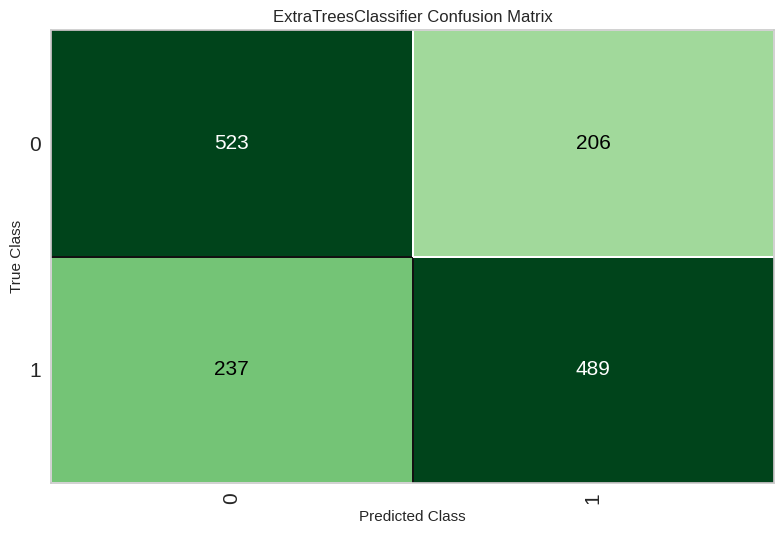

In [22]:
# plot confusion matrix
plot_model(tuned_model, plot = 'confusion_matrix')

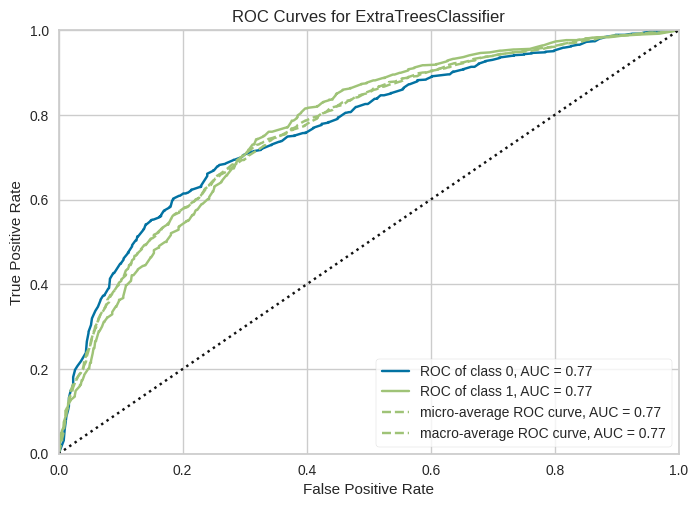

In [23]:
plot_model(tuned_model, plot = 'auc') # Erreur sur les matrices creuses, même en normalisant.

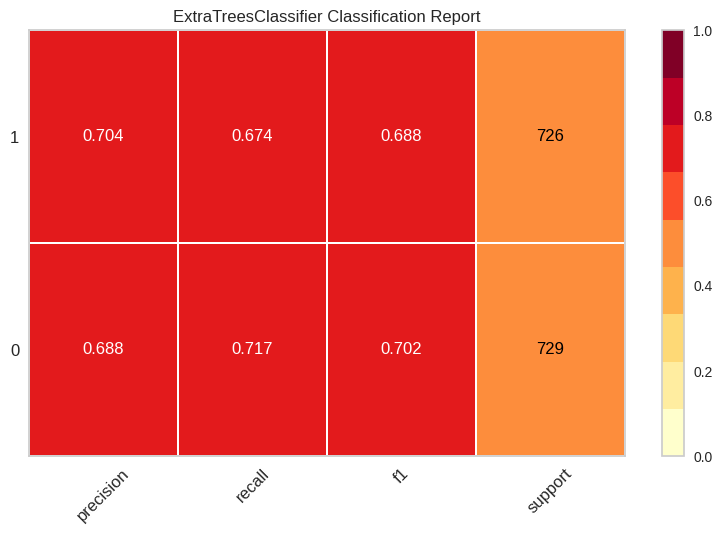

In [24]:
plot_model(tuned_model, plot = 'class_report') # boundary: Erreur sur les matrices creuses, même en normalisant.

In [25]:
pred_holdouts = predict_model(tuned_model)
pred_holdouts.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.6955,0.7679,0.6736,0.7036,0.6882,0.3910,0.3914


,00,0005,04,05,0530,0640hr,09,0910,10,100,...,zipped,zombie,zomg,zone,zoo,zune,zurich,target,prediction_label,prediction_score
3395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.8100
3396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.7233
3397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.6067
3398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.7400
3399,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.8900


In [26]:
pred_holdouts.shape

(1455, 6479)

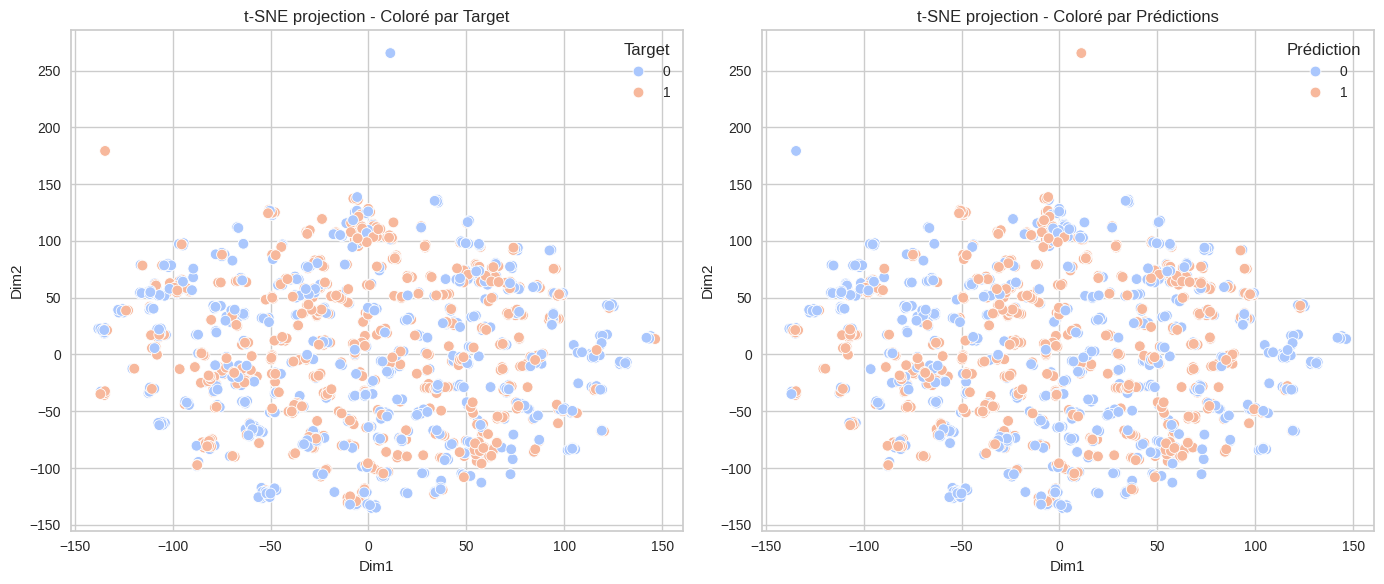

In [56]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Préparation des données : Extraire les colonnes à projeter
X = pred_holdouts.drop(['target', 'prediction_label', 'prediction_score'], axis=1)

# 2. Réduction de dimensionnalité avec PCA avant t-SNE
pca = PCA(n_components=50)  # Réduire à 50 dimensions pour conserver la structure
X_pca = pca.fit_transform(X)

# 3. Application de t-SNE avec le solveur arpack
tsne = TSNE(n_components=2, random_state=42, method='barnes_hut', n_iter=2000, perplexity=2, init="random", learning_rate=300)
X_tsne = tsne.fit_transform(X_pca)

# 4. Ajouter les vraies valeurs et les prédictions aux résultats t-SNE pour la visualisation
tsne_df = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
tsne_df['target'] = pred_holdouts['target'].values
tsne_df['prediction_label'] = pred_holdouts['prediction_label'].values

# 5. Création des graphes t-SNE colorés par les vraies valeurs et par les prédictions
plt.figure(figsize=(14, 6))

# Graphe à gauche: coloré par les vraies valeurs (target)
plt.subplot(1, 2, 1)
sns.scatterplot(x='Dim1', y='Dim2', hue='target', data=tsne_df, palette='coolwarm', s=60)
plt.title('t-SNE projection - Coloré par Target')
plt.legend(title='Target', loc='best')

# Graphe à droite: coloré par les prédictions (prediction_label)
plt.subplot(1, 2, 2)
sns.scatterplot(x='Dim1', y='Dim2', hue='prediction_label', data=tsne_df, palette='coolwarm', s=60)
plt.title('t-SNE projection - Coloré par Prédictions')
plt.legend(title='Prédiction', loc='best')

plt.tight_layout()
plt.show()


In [28]:
# Finalize the model (train on the entire dataset)
finalize_model(tuned_model)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['00', '0005', '04', '05', '0530',
                                             '0640hr', '09', '0910', '10',
                                             '100', '1000', '10010', '100bt',
                                             '100mi', '100mph', '1010', '1020',
                                             '1039', '1040', '105', '106',
                                             '106npark', '108', '1080p',
                                             '10hrs', '10pm', '10th', '10x',
                                             '10x10', '11', ...],
                                    transformer=SimpleImputer(add_i...
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, max_features='sqrt',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      monotonic_cst=None, n_estimators=100,
                                      n_jobs=-1, oob_score=False,
                                      random_state=123, verbose=0,
                                      warm_start=False))],
         verbose=False)

In [58]:
# save_model(best, model_name='CountVectorizer_Best_Model')

import os
from datetime import date, datetime

# os.chdir("C:/users/Cecil/Documents/oc_aiep7")
PATH = os.getcwd()+os.sep
current_time = datetime.now().strftime("%m-%d-%Y_%H-%M")
save_model(tuned_model, PATH + "models" + os.sep + "best_model_CountVectorizer_" + current_time)


# loaded_bestmodel = load_model('CountVectorizer_Best_Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['00', '0005', '04', '05', '0530',
                                              '0640hr', '09', '0910', '10',
                                              '100', '1000', '10010', '100bt',
                                              '100mi', '100mph', '1010', '1020',
                                              '1039', '1040', '105', '106',
                                              '106npark', '108', '1080p',
                                              '10hrs', '10pm', '10th', '10x',
                                              '10x10', '11', ...],
                                     transformer=SimpleImputer(add_i...
                  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       m

#### TFIdF

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 2,max_df = 0.5,ngram_range = (1,2))
train_tfidf_sparse = tfidf.fit_transform(train_df['preprocessed_text'])
test_tfidf_sparse = tfidf.transform(test_df['preprocessed_text'])

In [61]:
import scipy.sparse
train_tfidf = pd.DataFrame.sparse.from_spmatrix(train_tfidf_sparse, columns=tfidf.get_feature_names_out())
test_tfidf = pd.DataFrame.sparse.from_spmatrix(test_tfidf_sparse, columns=tfidf.get_feature_names_out())

In [62]:
from scipy.sparse import csr_matrix, hstack
train_tfidf["target"] = y_train.values
test_tfidf["target"] = y_test.values

In [ ]:
# import pycaret classification and init setup
from pycaret.classification import *
s_tf = setup(data=train_tfidf, target='target', test_data=test_tfidf, session_id = 123, index=False, use_gpu=True)


In [64]:
# import ClassificationExperiment and init the class
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()


In [65]:
# check the type of exp A CHANGER POUR MLFLOW à ce moment là le setup se fait avec 
type(exp)
# exp.setup(data, target = 'Class variable', session_id = 123)

pycaret.classification.oop.ClassificationExperiment

In [66]:
# compare baseline models and returns the best 6 ones
best_models_tf = compare_models(sort='Precision', n_select=6)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7052,0.7891,0.7271,0.6970,0.7108,0.4104,0.4120,2.7310
ridge,Ridge Classifier,0.6996,0.7739,0.7211,0.6910,0.7048,0.3992,0.4008,2.8650
et,Extra Trees Classifier,0.7140,0.7936,0.7838,0.6879,0.7320,0.4282,0.4336,2.9130
svm,SVM - Linear Kernel,0.6840,0.7537,0.6910,0.6813,0.6850,0.3679,0.3691,2.8740
catboost,CatBoost Classifier,0.7010,0.7727,0.7596,0.6795,0.7169,0.4022,0.4056,29.2870
xgboost,Extreme Gradient Boosting,0.6996,0.7680,0.7608,0.6771,0.7163,0.3993,0.4027,4.8780
rf,Random Forest Classifier,0.6975,0.7781,0.7820,0.6684,0.7202,0.3953,0.4022,2.9940
lightgbm,Light Gradient Boosting Machine,0.6733,0.7497,0.7070,0.6616,0.6832,0.3468,0.3481,2.8760
knn,K Neighbors Classifier,0.6518,0.7035,0.6568,0.6499,0.6527,0.3037,0.3042,2.9020
dt,Decision Tree Classifier,0.6486,0.6486,0.6692,0.6417,0.6548,0.2973,0.2980,2.8960


In [67]:
# Amélioration du meilleur modèle (logistic regression)
tuned_model_tf = tune_model(estimator=best_models_tf[0], 
                         optimize="Precision", choose_better=True,
                         verbose=False)

In [68]:
tuned_model_tf

LogisticRegression(C=0.056, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

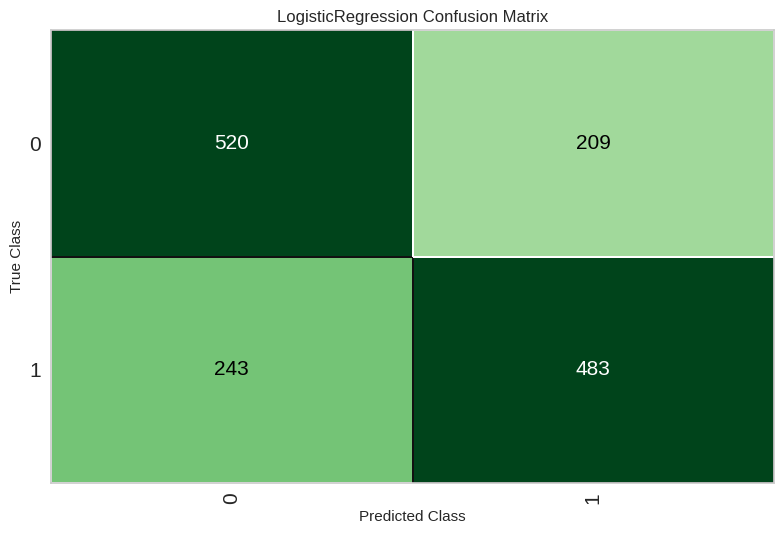

In [69]:
# plot confusion matrix
plot_model(tuned_model_tf, plot = 'confusion_matrix')

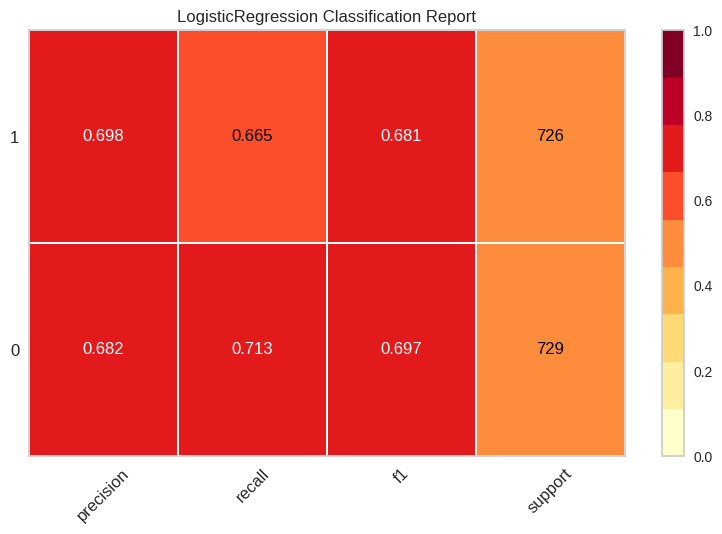

In [71]:
plot_model(tuned_model_tf, plot = 'class_report')

In [75]:
pred_holdouts_tf = predict_model(tuned_model_tf)
pred_holdouts_tf.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6893,0.7669,0.6653,0.6980,0.6812,0.3786,0.3790


,00,10,10 day,10 hour,10 min,100,106,106 flight,10pm,10th,...,you,young,youtube,yr,yum,yummy,yup,target,prediction_label,prediction_score
3395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.5170
3396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.5325
3397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.5227
3398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.5058
3399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.5051


In [76]:
# Finalize the model (train on the entire dataset)
finalize_model(tuned_model_tf)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['00', '10', '10 day', '10 hour',
                                             '10 min', '100', '106',
                                             '106 flight', '10pm', '10th', '11',
                                             '12', '12 hour', '12 hr',
                                             '12 week', '125', '13', '14',
                                             '14 hour', '14 hr', '15', '15 hr',
                                             '15 min', '17', '17th', '18',
                                             '18 hour', '19', '1am', '1st', ...],
                                    transformer=SimpleImputer(add_indic...
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
                ('actual_estimator',
                 LogisticRegression(C=0.056, class_weight={}, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=123,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [77]:
# save_model(best, model_name='CountVectorizer_Best_Model')

import os
from datetime import date, datetime

# os.chdir("C:/users/Cecil/Documents/oc_aiep7")
PATH = os.getcwd()+os.sep
current_time = datetime.now().strftime("%m-%d-%Y_%H-%M")
save_model(tuned_model_tf, PATH + "models" + os.sep + "best_model_TFIdF_" + current_time)


# loaded_bestmodel = load_model('CountVectorizer_Best_Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['00', '10', '10 day', '10 hour',
                                              '10 min', '100', '106',
                                              '106 flight', '10pm', '10th', '11',
                                              '12', '12 hour', '12 hr',
                                              '12 week', '125', '13', '14',
                                              '14 hour', '14 hr', '15', '15 hr',
                                              '15 min', '17', '17th', '18',
                                              '18 hour', '19', '1am', '1st', ...],
                                     transformer=SimpleImputer(add_indic...
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
       